# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

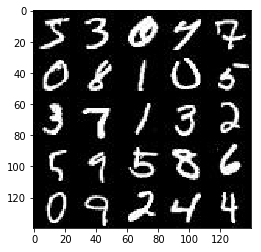

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot


mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

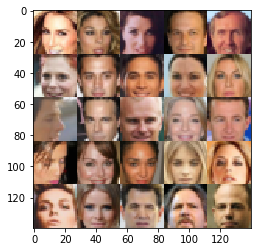

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# additional functions

# for debugging - print out the tensor shapes
def tensor_shape(t):
    print('shape: ' + str(t.shape))

# switch for using leaky relu or not
def relu_type(leaky, alpha, t):
        if leaky == 1:
            a = tf.maximum(alpha * t, t)
        else:
            a = tf.nn.relu(t)
        return a
    
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.9
    
    # define sizes - from 28 > 14 > 7 > 4 
    size = 64
    sz_1, sz_2, sz_3 = size*1, size*2, size*4
    
    use_leaky_relu = 1 # switch to use either (1==yes, 0==No)
    
    with tf.variable_scope('discriminator', reuse=reuse) as discrim_scope:
        # create conv net with input images that are 28 x 28 x 3 (channel for the face data)
        # tf.layers.dense([input_image], filter depth, kernel size, strides, padding)
        disc_1 = tf.layers.conv2d(images, sz_1, 5, strides=2, 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                  padding='same')
        relu_1 = tf.nn.dropout(relu_type(use_leaky_relu, alpha, disc_1), keep_prob)
        # output size: 14 x 14 x 64
        
        disc_2 = tf.layers.conv2d(relu_1, sz_2, 5, strides=2,
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                  padding='same')
        bn_2 = tf.layers.batch_normalization(disc_2, training=True)
        relu_2 = tf.nn.dropout(relu_type(use_leaky_relu, alpha, bn_2), keep_prob)
        # output size: 7 x 7 x 128
        
        disc_3 = tf.layers.conv2d(relu_2, sz_3, 5, strides=2,
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                  padding='same')
        bn_3 = tf.layers.batch_normalization(disc_3, training=True)
        relu_3 = tf.nn.dropout(relu_type(use_leaky_relu, alpha, bn_3), keep_prob)
        # output size: 4 x 4 x 256
        
        # flatten the shape
        flat = tf.reshape(relu_3, (-1, 2*2*sz_3))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        # bebug - print shapes
#         tensor_shape(images)
#         tensor_shape(relu_1)
#         tensor_shape(relu_2)
#         tensor_shape(relu_3)
#         tensor_shape(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.5
    use_leaky_relu = 1 # switch to use either (1==yes, 0==No)
    
    size = 64
    sz_1, sz_2_2, sz_2, sz_3 = size*1, size*2, size*8, size*16
    
    reuse = not is_train # need to set this value from something
    training = is_train # keeps is similar to the lessons to avoid confusion
    
    with tf.variable_scope('generator', reuse=reuse) as gen_scope:
        # this must be the reverse of the discriminator
        gen_1 = tf.layers.dense(z, 4 * 4 * sz_3)
        # reshapre to start conv transpose stack
        gen_1 = tf.reshape(gen_1, (-1, 4, 4, sz_3))
        gen_1 = tf.layers.batch_normalization(gen_1, training=training)
        gen_1 = relu_type(use_leaky_relu, alpha, gen_1)
        # gen_1 = tf.nn.dropout(gen_1, keep_prob)
        # output shape: 4 x 4 x 1024
        
        gen_2 = tf.layers.conv2d_transpose(gen_1, sz_2, 4, strides=1,
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding='valid')
        gen_2 = tf.layers.batch_normalization(gen_2, training=training)
        gen_2 = relu_type(use_leaky_relu, alpha, gen_2)
        # gen_2 = tf.nn.dropout(gen_2, keep_prob)
        # output shape: 7 x 7 x 512
        
#         gen_2_2 = tf.layers.conv2d_transpose(gen_2, sz_2_2, 4, strides=1,
#                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
#                                            padding='same')
#         gen_2_2 = tf.layers.batch_normalization(gen_2_2, training=training)
#         gen_2_2 = relu_type(use_leaky_relu, alpha, gen_2_2)
        # output shape: 7 x 7 x 128
        
        gen_3 = tf.layers.conv2d_transpose(gen_2, sz_1, 4, strides=2,
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding='same')
        gen_3 = tf.layers.batch_normalization(gen_3, training=training)
        # gen_3 = tf.nn.dropout(relu_type(use_leaky_relu, alpha, gen_3), keep_prob)
        gen_3 = tf.layers.dropout(relu_type(use_leaky_relu, alpha, gen_3),
                                  rate=keep_prob,
                                  training=training)
        # gen_3 = relu_type(use_leaky_relu, alpha, gen_3)
        # output size: 14 x 14 x 64  
        
        # output layer
        logits = tf.layers.conv2d_transpose(gen_3, out_channel_dim, 4, strides=2,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                            padding='same')
        # output size: 28 x 28 x out_channel_dim
        
        out = tf.tanh(logits)
        
        
        # bebug - print shapes
#         tensor_shape(z)
#         tensor_shape(gen_1)
#         tensor_shape(gen_2)
# #         tensor_shape(gen_2_2)
#         tensor_shape(gen_3)
#         tensor_shape(logits)
#         print(out_channel_dim)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth_param = 0.1 # smoothing parameter
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real) * (1-smooth_param)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                        labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                        labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function    
    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith('disc')]
    g_vars = [v for v in t_vars if v.name.startswith('gen')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # optimize
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#         d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
#         g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # tf.reset_default_graph()
    # vars needed 
    # samples, losses = [], []
    losses = []
    count_itters = 0 # to count itterations
    print_every = 10 # print state every itterations
    show_every = 100 # show state every itterations
    fig_size = (5, 5)
    
    # print('data image mode: ' + str(data_image_mode))
    
    # keep var names here the same as the reutrns from the functions for sanity
    # inputs
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    # optimization
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # start the session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # count iterations
                count_itters += 1
                
                # batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
                
                # Sample random noise for the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # batch_z = batch_z.reshape(batch_size, z_dim)
                
                # run optimizers
                # discriminator
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, 
                                                     lr: learning_rate})
                # generator
                for g_runs in range(2):
                    _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images,
                                                         lr: learning_rate})
                
                
                if count_itters % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # save losses for review after training
                    losses.append((train_loss_d, train_loss_g))
                
                if (count_itters % show_every == 0) or count_itters == 1:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
                    
    # plot losses 
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

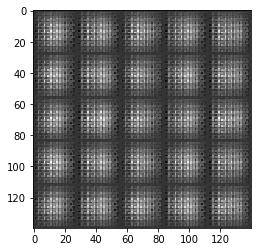

Epoch 1/2... Discriminator Loss: 0.8769... Generator Loss: 4.1791
Epoch 1/2... Discriminator Loss: 1.6456... Generator Loss: 0.8051
Epoch 1/2... Discriminator Loss: 1.6217... Generator Loss: 0.8446
Epoch 1/2... Discriminator Loss: 1.2076... Generator Loss: 1.1159
Epoch 1/2... Discriminator Loss: 1.6114... Generator Loss: 0.6841
Epoch 1/2... Discriminator Loss: 1.3464... Generator Loss: 0.9031
Epoch 1/2... Discriminator Loss: 1.6179... Generator Loss: 0.5813
Epoch 1/2... Discriminator Loss: 1.5197... Generator Loss: 0.7791
Epoch 1/2... Discriminator Loss: 1.5771... Generator Loss: 0.5604
Epoch 1/2... Discriminator Loss: 1.2974... Generator Loss: 0.8434


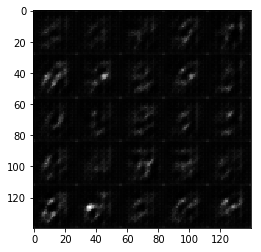

Epoch 1/2... Discriminator Loss: 1.3508... Generator Loss: 0.7378
Epoch 1/2... Discriminator Loss: 1.4538... Generator Loss: 0.6736
Epoch 1/2... Discriminator Loss: 1.5520... Generator Loss: 1.1813
Epoch 1/2... Discriminator Loss: 1.2971... Generator Loss: 0.9397
Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 0.7576
Epoch 1/2... Discriminator Loss: 1.4260... Generator Loss: 1.2362
Epoch 1/2... Discriminator Loss: 1.3500... Generator Loss: 0.8148
Epoch 1/2... Discriminator Loss: 1.4590... Generator Loss: 0.7339
Epoch 1/2... Discriminator Loss: 1.5105... Generator Loss: 1.0509
Epoch 1/2... Discriminator Loss: 1.3960... Generator Loss: 1.1313


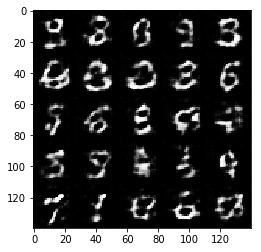

Epoch 1/2... Discriminator Loss: 1.4100... Generator Loss: 0.7395
Epoch 1/2... Discriminator Loss: 1.3428... Generator Loss: 0.8770
Epoch 1/2... Discriminator Loss: 1.3846... Generator Loss: 0.7209
Epoch 1/2... Discriminator Loss: 1.3904... Generator Loss: 0.6793
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.7898
Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.9731
Epoch 1/2... Discriminator Loss: 1.4335... Generator Loss: 0.8251
Epoch 1/2... Discriminator Loss: 1.3362... Generator Loss: 0.8790
Epoch 1/2... Discriminator Loss: 1.4738... Generator Loss: 0.8244
Epoch 1/2... Discriminator Loss: 1.6267... Generator Loss: 1.2602


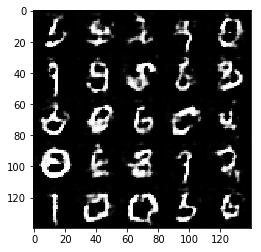

Epoch 1/2... Discriminator Loss: 1.3305... Generator Loss: 0.7870
Epoch 1/2... Discriminator Loss: 1.3310... Generator Loss: 0.8471
Epoch 1/2... Discriminator Loss: 1.3127... Generator Loss: 0.8132
Epoch 1/2... Discriminator Loss: 1.3692... Generator Loss: 0.8619
Epoch 1/2... Discriminator Loss: 1.4586... Generator Loss: 0.4961
Epoch 1/2... Discriminator Loss: 1.3980... Generator Loss: 0.7699
Epoch 1/2... Discriminator Loss: 1.4550... Generator Loss: 0.8068
Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 0.7890
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.7505
Epoch 1/2... Discriminator Loss: 1.4012... Generator Loss: 0.7603


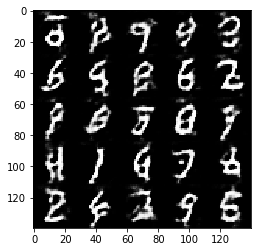

Epoch 1/2... Discriminator Loss: 1.5573... Generator Loss: 0.4543
Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 0.7905
Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 0.8715
Epoch 1/2... Discriminator Loss: 1.5904... Generator Loss: 1.4174
Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 0.8974
Epoch 1/2... Discriminator Loss: 1.3527... Generator Loss: 0.8398
Epoch 1/2... Discriminator Loss: 1.4002... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 1.3375... Generator Loss: 0.7504
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 1.0044
Epoch 1/2... Discriminator Loss: 1.3280... Generator Loss: 0.8581


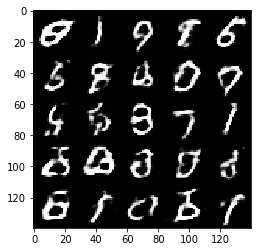

Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.9804
Epoch 1/2... Discriminator Loss: 1.3261... Generator Loss: 0.8044
Epoch 1/2... Discriminator Loss: 1.5732... Generator Loss: 1.4453
Epoch 1/2... Discriminator Loss: 1.3556... Generator Loss: 0.8412
Epoch 1/2... Discriminator Loss: 1.4615... Generator Loss: 0.5524
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 0.6888
Epoch 1/2... Discriminator Loss: 1.3770... Generator Loss: 0.7326
Epoch 1/2... Discriminator Loss: 1.5776... Generator Loss: 0.4336
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 0.8117


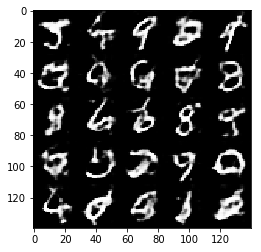

Epoch 1/2... Discriminator Loss: 1.3829... Generator Loss: 0.7422
Epoch 1/2... Discriminator Loss: 1.3531... Generator Loss: 0.7968
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.7354
Epoch 1/2... Discriminator Loss: 1.3661... Generator Loss: 0.8322
Epoch 1/2... Discriminator Loss: 1.4755... Generator Loss: 0.4581
Epoch 1/2... Discriminator Loss: 1.3165... Generator Loss: 0.8520
Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 0.8302
Epoch 1/2... Discriminator Loss: 1.4663... Generator Loss: 0.6947
Epoch 1/2... Discriminator Loss: 1.4045... Generator Loss: 0.5587
Epoch 1/2... Discriminator Loss: 1.4225... Generator Loss: 0.6314


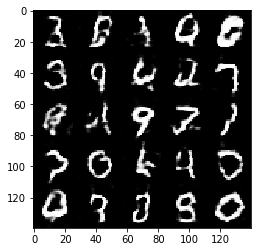

Epoch 1/2... Discriminator Loss: 1.4040... Generator Loss: 0.7545
Epoch 1/2... Discriminator Loss: 1.4375... Generator Loss: 0.8539
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.8323
Epoch 1/2... Discriminator Loss: 1.3673... Generator Loss: 0.8105
Epoch 1/2... Discriminator Loss: 1.3222... Generator Loss: 0.7657
Epoch 1/2... Discriminator Loss: 1.2653... Generator Loss: 0.9685
Epoch 1/2... Discriminator Loss: 1.2942... Generator Loss: 0.8334
Epoch 1/2... Discriminator Loss: 1.3576... Generator Loss: 0.9159
Epoch 1/2... Discriminator Loss: 1.2539... Generator Loss: 0.7366
Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 1.0183


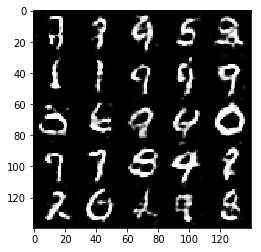

Epoch 1/2... Discriminator Loss: 1.3368... Generator Loss: 0.7150
Epoch 1/2... Discriminator Loss: 1.2327... Generator Loss: 1.0042
Epoch 1/2... Discriminator Loss: 1.2973... Generator Loss: 0.8778
Epoch 1/2... Discriminator Loss: 1.2187... Generator Loss: 1.0208
Epoch 1/2... Discriminator Loss: 1.2145... Generator Loss: 0.9325
Epoch 1/2... Discriminator Loss: 1.4207... Generator Loss: 0.6197
Epoch 1/2... Discriminator Loss: 1.4508... Generator Loss: 0.7387
Epoch 1/2... Discriminator Loss: 1.2553... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 1.2289... Generator Loss: 0.8771
Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 0.6621


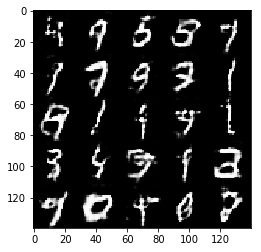

Epoch 1/2... Discriminator Loss: 1.3415... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.3245... Generator Loss: 0.6499
Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 0.5853
Epoch 2/2... Discriminator Loss: 1.2870... Generator Loss: 0.7049
Epoch 2/2... Discriminator Loss: 1.2554... Generator Loss: 0.9037
Epoch 2/2... Discriminator Loss: 1.2731... Generator Loss: 1.2093
Epoch 2/2... Discriminator Loss: 1.3696... Generator Loss: 0.8572
Epoch 2/2... Discriminator Loss: 1.9634... Generator Loss: 1.7478
Epoch 2/2... Discriminator Loss: 1.4462... Generator Loss: 0.7976
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.7844


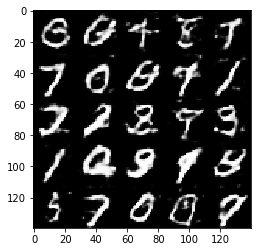

Epoch 2/2... Discriminator Loss: 1.3099... Generator Loss: 0.8348
Epoch 2/2... Discriminator Loss: 1.3240... Generator Loss: 0.8390
Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.6890
Epoch 2/2... Discriminator Loss: 1.6990... Generator Loss: 1.7130
Epoch 2/2... Discriminator Loss: 1.2830... Generator Loss: 0.8040
Epoch 2/2... Discriminator Loss: 1.2251... Generator Loss: 0.7863
Epoch 2/2... Discriminator Loss: 1.3099... Generator Loss: 0.8162
Epoch 2/2... Discriminator Loss: 1.2893... Generator Loss: 0.7798
Epoch 2/2... Discriminator Loss: 1.3111... Generator Loss: 0.6623
Epoch 2/2... Discriminator Loss: 1.3935... Generator Loss: 0.6712


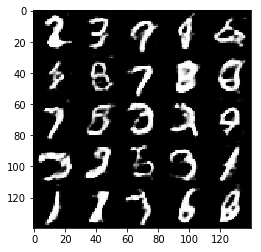

Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 0.8554
Epoch 2/2... Discriminator Loss: 1.2450... Generator Loss: 0.7672
Epoch 2/2... Discriminator Loss: 1.2209... Generator Loss: 1.0197
Epoch 2/2... Discriminator Loss: 1.3280... Generator Loss: 0.5809
Epoch 2/2... Discriminator Loss: 1.3667... Generator Loss: 0.7542
Epoch 2/2... Discriminator Loss: 1.2860... Generator Loss: 1.0087
Epoch 2/2... Discriminator Loss: 1.2219... Generator Loss: 1.0698
Epoch 2/2... Discriminator Loss: 1.3542... Generator Loss: 0.8438
Epoch 2/2... Discriminator Loss: 1.1608... Generator Loss: 0.7523
Epoch 2/2... Discriminator Loss: 1.4655... Generator Loss: 0.4740


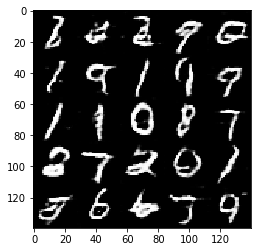

Epoch 2/2... Discriminator Loss: 1.2341... Generator Loss: 0.8668
Epoch 2/2... Discriminator Loss: 1.3743... Generator Loss: 0.6183
Epoch 2/2... Discriminator Loss: 1.3126... Generator Loss: 0.8484
Epoch 2/2... Discriminator Loss: 1.2310... Generator Loss: 0.8743
Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 0.6429
Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 0.9477
Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.8698
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.5469
Epoch 2/2... Discriminator Loss: 1.3035... Generator Loss: 1.2287
Epoch 2/2... Discriminator Loss: 1.3034... Generator Loss: 0.7714


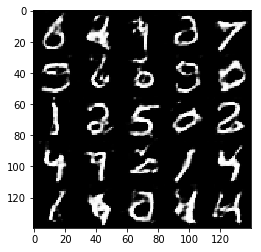

Epoch 2/2... Discriminator Loss: 1.2987... Generator Loss: 0.7094
Epoch 2/2... Discriminator Loss: 1.5026... Generator Loss: 0.5776
Epoch 2/2... Discriminator Loss: 1.2026... Generator Loss: 0.8613
Epoch 2/2... Discriminator Loss: 1.2208... Generator Loss: 1.3341
Epoch 2/2... Discriminator Loss: 1.7989... Generator Loss: 0.3146
Epoch 2/2... Discriminator Loss: 1.3677... Generator Loss: 0.6985
Epoch 2/2... Discriminator Loss: 1.1976... Generator Loss: 0.8193
Epoch 2/2... Discriminator Loss: 1.2786... Generator Loss: 1.4364
Epoch 2/2... Discriminator Loss: 1.1638... Generator Loss: 0.8708
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 1.3546


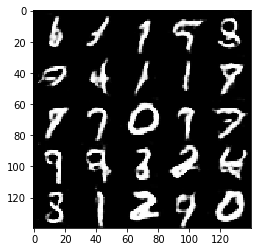

Epoch 2/2... Discriminator Loss: 1.4566... Generator Loss: 0.5324
Epoch 2/2... Discriminator Loss: 1.2542... Generator Loss: 0.7932
Epoch 2/2... Discriminator Loss: 1.1740... Generator Loss: 0.8664
Epoch 2/2... Discriminator Loss: 1.2469... Generator Loss: 1.0693
Epoch 2/2... Discriminator Loss: 1.2816... Generator Loss: 0.9525
Epoch 2/2... Discriminator Loss: 1.1956... Generator Loss: 0.7680
Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 0.7531
Epoch 2/2... Discriminator Loss: 1.2243... Generator Loss: 0.6902
Epoch 2/2... Discriminator Loss: 1.3739... Generator Loss: 0.6112
Epoch 2/2... Discriminator Loss: 1.0995... Generator Loss: 0.9582


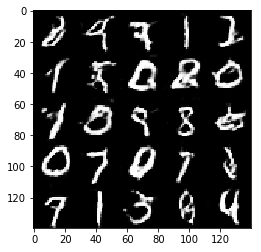

Epoch 2/2... Discriminator Loss: 1.0873... Generator Loss: 0.7650
Epoch 2/2... Discriminator Loss: 1.2606... Generator Loss: 1.0519
Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 1.6962
Epoch 2/2... Discriminator Loss: 1.1471... Generator Loss: 0.7623
Epoch 2/2... Discriminator Loss: 1.0749... Generator Loss: 0.9212
Epoch 2/2... Discriminator Loss: 1.0933... Generator Loss: 1.1150
Epoch 2/2... Discriminator Loss: 1.3070... Generator Loss: 0.6382
Epoch 2/2... Discriminator Loss: 1.4733... Generator Loss: 0.4752
Epoch 2/2... Discriminator Loss: 1.3176... Generator Loss: 0.6300
Epoch 2/2... Discriminator Loss: 1.1020... Generator Loss: 1.0337


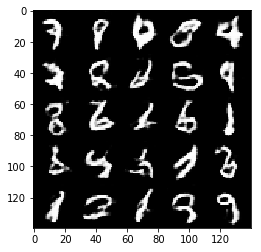

Epoch 2/2... Discriminator Loss: 1.3178... Generator Loss: 0.6521
Epoch 2/2... Discriminator Loss: 1.0935... Generator Loss: 0.9170
Epoch 2/2... Discriminator Loss: 1.4684... Generator Loss: 0.4507
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.6259
Epoch 2/2... Discriminator Loss: 1.1069... Generator Loss: 0.8218
Epoch 2/2... Discriminator Loss: 1.1068... Generator Loss: 1.0516
Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 1.1790
Epoch 2/2... Discriminator Loss: 1.1521... Generator Loss: 0.8153
Epoch 2/2... Discriminator Loss: 1.2690... Generator Loss: 0.6691
Epoch 2/2... Discriminator Loss: 1.0326... Generator Loss: 0.9360


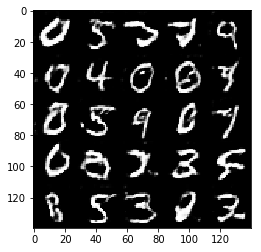

Epoch 2/2... Discriminator Loss: 1.3077... Generator Loss: 0.8560
Epoch 2/2... Discriminator Loss: 1.1419... Generator Loss: 1.2144
Epoch 2/2... Discriminator Loss: 1.2894... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 1.1104... Generator Loss: 0.8147
Epoch 2/2... Discriminator Loss: 1.2542... Generator Loss: 1.6720
Epoch 2/2... Discriminator Loss: 0.9835... Generator Loss: 1.0091
Epoch 2/2... Discriminator Loss: 1.0226... Generator Loss: 1.1616
Epoch 2/2... Discriminator Loss: 1.4283... Generator Loss: 0.5422
Epoch 2/2... Discriminator Loss: 1.0652... Generator Loss: 0.8025
Epoch 2/2... Discriminator Loss: 1.4771... Generator Loss: 0.7319


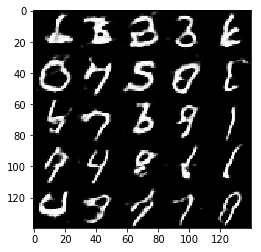

Epoch 2/2... Discriminator Loss: 1.1561... Generator Loss: 0.9077
Epoch 2/2... Discriminator Loss: 1.1571... Generator Loss: 0.6300
Epoch 2/2... Discriminator Loss: 1.4416... Generator Loss: 0.5941
Epoch 2/2... Discriminator Loss: 1.2772... Generator Loss: 1.3593
Epoch 2/2... Discriminator Loss: 1.4451... Generator Loss: 1.4984
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 1.1169
Epoch 2/2... Discriminator Loss: 1.1991... Generator Loss: 0.6832


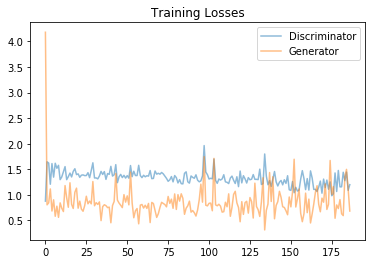

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

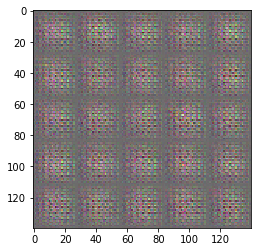

Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 3.2585
Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 1.6107
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 1.9175
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 2.0305
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 1.6048


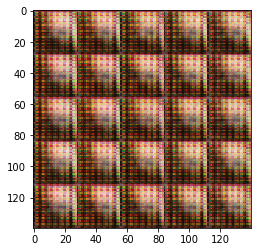

Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 1.7177
Epoch 1/1... Discriminator Loss: 0.6545... Generator Loss: 2.3196
Epoch 1/1... Discriminator Loss: 0.7022... Generator Loss: 1.7747
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 1.8874
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.4572
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.5073
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.5586


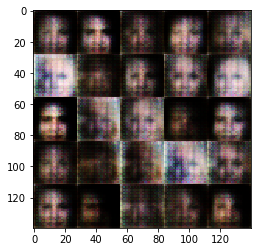

Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 1.2980
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 1.5392
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.5737
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.9386


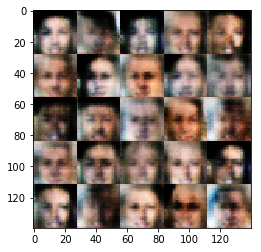

Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.8316


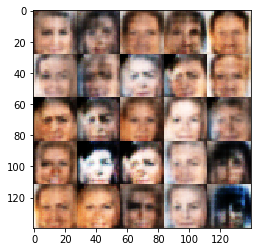

Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.9047
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.8466


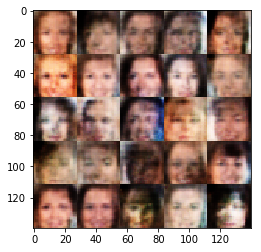

Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7618


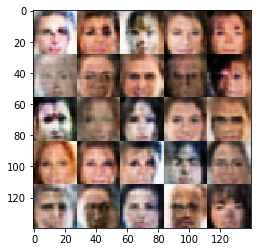

Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7695


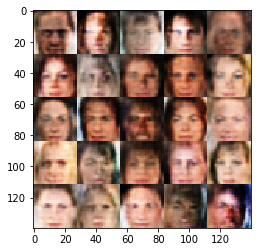

Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7640


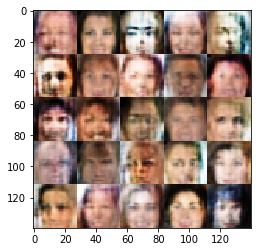

Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.8208


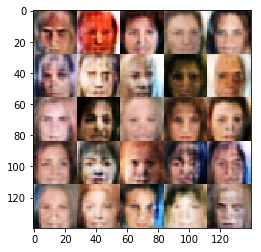

Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.7741


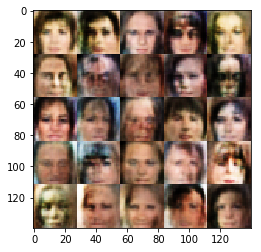

Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.8079


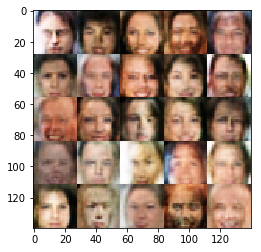

Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.8146


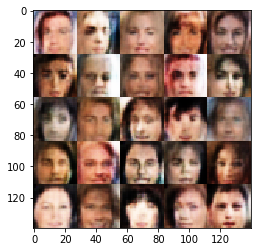

Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7996


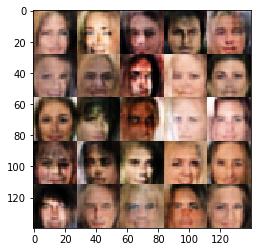

Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7954


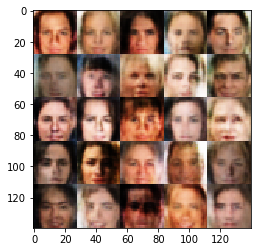

Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7902


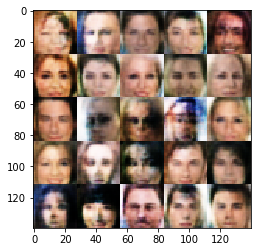

Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.7449


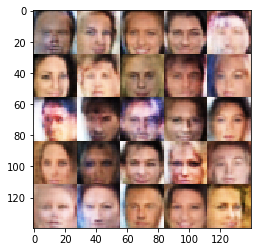

Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.8237


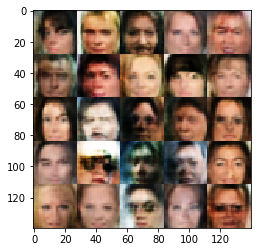

Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7413


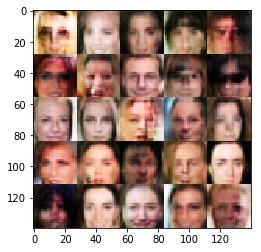

Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.8191


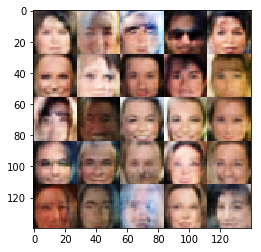

Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7844


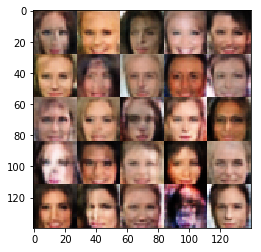

Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.8164


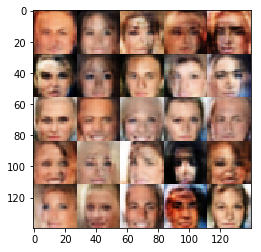

Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.8217


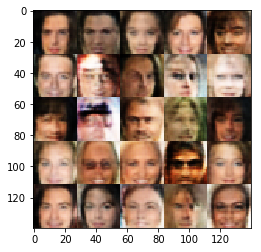

Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.8335


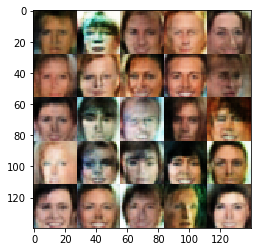

Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7760


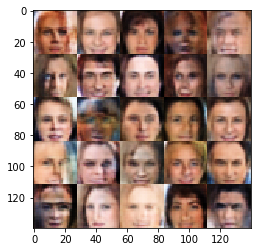

Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7517


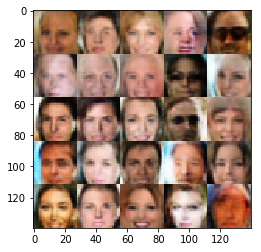

Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7316


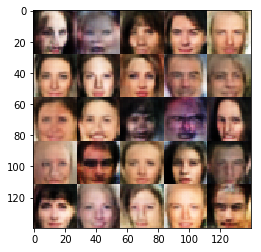

Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.7693


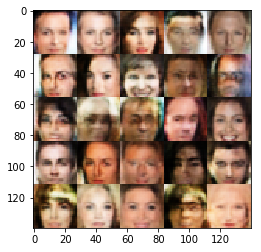

Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7174


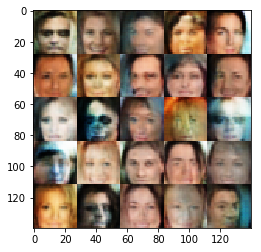

Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8056


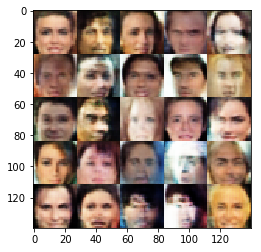

Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.7067


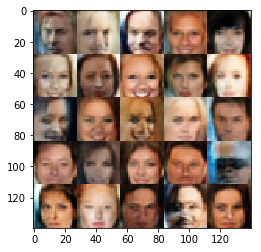

Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7464


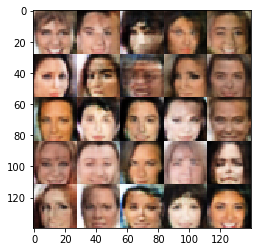

Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.6684


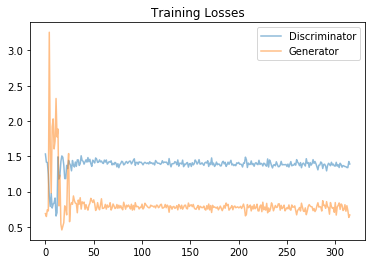

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.